In [1]:
import site, os
try:
    print(site.getsitepackages())
except:
    print(os.path.dirname(site.__file__) + '/site-packages')

/Users/csaintje/Documents/Recherche/Python/Envs/scientific_3_5/bin/../lib/python3.5/site-packages


In [2]:
import numpy as np
import scipy.integrate as sci
import scipy.optimize as sco
import scipy.stats as scs
import itertools as it
import matplotlib
%matplotlib inline
#print (matplotlib.rcsetup.interactive_bk)
#print (matplotlib.rcsetup.non_interactive_bk)
#print (matplotlib.rcsetup.all_backends)
print (matplotlib.get_backend())
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from joblib import Memory, Parallel, delayed, dump, load

module://ipykernel.pylab.backend_inline


In [3]:
import theano.tensor as T
import theano

Details for gaussian distribution as an exponential family

In [4]:
def lb2th(mu,sigma2):
    return mu / sigma2, 0.5 / sigma2

def lb2et(mu, sigma2):
    return mu, -(mu**2+sigma2)

def th2lb(th1,th2):
    return 0.5*th1/th2, 0.5 / th2

def th2et(th1,th2):
    return 0.5*th1/th2, 0.5*(-0.5*th1**2/th2 - 1) / th2

def et2lb(et1,et2):
    return et1, -(et1**2+et2)

def et2th(et1,et2):
    return - et1 /(et1**2 + et2), -0.5 /(et1**2 + et2)

def s_1(x):
    return x

def s_2(x):
    return -x*x

def F_1D(theta1,theta2):
    return 0.25*theta1*theta1/theta2 + 0.5*np.log(np.pi) - 0.5*np.log(theta2) 

def gradF_1_1D(theta_1,theta_2):
    return 0.5*theta_1/theta_2

def gradF_2_1D(theta_1, theta_2):
    temp_1 = 0.5 / theta_2
    temp_2 = temp_1 * theta_1
    return -1. * (temp_2 * temp_2 + temp_1)

def gradF_1_nD(theta_1,theta_2):
    return 0.5*np.dot(np.inv(theta_2), theta_1)

def gradF_2_nD(theta_1, theta_2):
    temp_1 = 0.5*np.inv(theta_2)
    temp_2 = np.dot(temp1,theta_1)
    return - np.outer(temp_2,temp_2) - temp_1

def gradG_1_1D(eta_1,eta_2):
    return eta1 / (-eta_1 * eta1 - eta2)

def gradG_2_1D(eta_1,eta_2):
    return 0.5  / (-eta_1 * eta1 - eta2)

def gradG_1_nD(eta_1,eta_2):
    return np.dot(np.inv(-np.outer(eta_1, eta1) - eta2), eta1)

def gradG_2_nD(eta_1,eta_2):
    return 0.5*np.inv(-np.outer(eta_1, eta1) - eta2)


Cas 1D - Data

In [5]:
seed = 13
np.random.seed(seed)
N, batch_size = 20000*4, 100
mu_true, sigma_true = 1, 2
sigma2_true = sigma_true**2
theta1_true, theta2_true = lb2th(mu_true, sigma2_true)
eta1_true, eta2_true = lb2et(mu_true, sigma2_true)
X = np.random.normal(mu_true,np.sqrt(sigma2_true), N)
replicate = 100
mu_0, sigma2_0 = 0, 10
a_0 = 1 
lb_init = [(mu, sigma2) for mu, sigma2 in 
           zip(np.random.normal(mu_0,np.sqrt(sigma2_0), replicate),
               scs.invgamma.rvs(a_0, size=replicate))]
th_init = [lb2th(mu, sigma2) for mu, sigma2 in lb_init]
et_init = [lb2et(mu, sigma2) for mu, sigma2 in lb_init]
#print(lb_init, th_init, et_init)
def batches(Y, bs):
    nb = np.int(np.ceil(len(Y) / bs))
    Yb = [Y[i * bs : (i+1) * bs] for i in range(nb)]
    def __temp(i):
        return Yb[i]
    return nb, Yb, __temp

Xt = X[: N//4]
Nt = len(Xt)
NtB, XtB, XtB_f = batches(Xt, batch_size)
Xv = X[N//4 : N//2]
Nv = len(Xv)
NvB, XvB, XvB_f = batches(Xv, batch_size)
Xtest = X[N//2:]

In [53]:
def ll(x, mu, sigma2):
    #assert(sigma2 > 0)
    return -(x - mu)**2 /(2 * sigma2) - np.log(np.sqrt(2 * sigma2 * np.pi)) 

def ll_theta(x, theta1, theta2):
    return s_1(x) * theta1 + s_2(x) * theta2 - F_1D(theta1, theta2)

def ll_eta(x, eta1, eta2):
    theta1 = - eta1 / (eta1*eta1 + eta2)
    theta2 = - 0.5  / (eta1*eta1 + eta2)
    return ll_theta(x, theta1, theta2)

def kl(mu_1, s_1, mu_2, s_2):
    #assert(s_1 > 0 and s_2 > 0)
    val = 0.5*(np.log(s_2/s_1) + (s_1/s_2) + ((mu_1 - mu_2)**2 / s_2)  - 1)
    return val
    
def ave_ll(mu, sigma2, chi):
    N = len(chi)
    #assert(sigma2 > 0)
    return (1. / N) * sum(ll(x, mu, sigma2) for x in chi)
    
def C_N(mu, sigma2, chi):
    #assert(sigma2 > 0)
    return -ave_ll(mu, sigma2, chi)

np.testing.assert_allclose(ll(4, mu_true, sigma2_true),
                          ll_theta(4, theta1_true, theta2_true))
np.testing.assert_allclose(ll(4, mu_true, sigma2_true),
                          ll_eta(4, eta1_true, eta2_true))

# Points stationnaires de $C(\theta) = \mathbb{E}_{\pi} [C(\theta,x)] = \mathbb{E}_{\pi} [-\log p(x;\theta)]$ par Robbins-Monro


### Robbins-Monro

On dispose d'une fonction inconnue (supposée monotone) $M(\theta)$ telle que 
$$M(\theta) = \mathbb{E}_{\pi(\beta|\theta)} [\beta]$$ 
avec $\beta$ une v.a désignant des observations bruitées de $M(\theta)$.

On cherche la valeur $\theta^*$ telle que $M(\theta^*) = \alpha$.

Suite convergente de Robbins-Monro : $$\theta^{(t+1)} - \theta^{(t)} = a^{(t)} (\alpha - \beta^{(t)})$$

### Robbins-Monro  et gradient stochastique

$M(\theta) := \nabla_{\theta} C(\theta)$ est le gradient d'une fonction inconnue $C$. 

On cherche la valeur $\theta^*$ telle que $M(\theta^*) = \nabla C(\theta^*) = 0$.

Suite convergente de Robbins-Monro : $$\theta^{(t+1)} = \theta^{(t)} - a^{(t)} \beta^{(t)}$$
où $\beta^{(t)}$ est une observation bruitée de $\nabla_{\theta} C(\theta^{(t)})$.

### Pour notre cas
La fonction à minimiser est:
$$C(\theta) = \mathbb{E}_{\pi} [- \log p(x;\theta)]$$
où $\pi$ est la distribution inconnue dont on cherche une approximation $p$ paramétrée par $\theta$ (identique à la minimisation sur $\theta$ de $KL(\pi || p(.;\theta))$)

Son équivalent en discret:
$$C_N(\theta) = - N^{-1} \sum_i \log p(x_i;\theta)$$
avec $\lim_{N \rightarrow +\infty} C_N(\theta) = C(\theta)$ 

Sous conditions de regularité et dans la famille exponentielle, 
$$\nabla_{\theta} C(\theta) = \mathbb{E}_{\pi} [- \nabla_{\theta}\log p(x;\theta)]  = \mathbb{E}_{\pi} [- s(x) + \nabla_{\theta} F (\theta)]$$

Pour le relier à Robbin-Monro, on a une observation bruitée
$$\beta^{(t)} = - s(x^{(t)}) + \nabla_{\theta} F (\theta^{(t)})$$
et donc la suite convergente $$\theta^{(t+1)} = \theta^{(t)} + a^{(t)} (s(x^{(t)}) - \nabla_{\theta} F (\theta^{(t)}))$$

Est ce que la formulation suivante est équivalente ? sans doute non ...
$$\eta^{(t+1)} = \eta^{(t)} + a^{(t)} (s(x^{(t)}) - \eta^{(t)}))$$

Dans l'espace $H$ (paramètre d'espérance), la même optimisation:
$$C(\eta) = \mathbb{E}_{\pi} [- \log p(x;\eta)] = \mathbb{E}_{\pi} [B_{F^*}(s(x) : \eta) - F^*(s(x)) - k(x)]$$
$$\nabla_{\eta} C(\eta) = \mathbb{E}_{\pi} [\nabla_{\eta} B_{F^*}(s(x) : \eta)] = \mathbb{E}_{\pi} [\nabla_{\eta} (F^*(s(x)) - F^*(\eta) - <s(x) - \eta, \nabla_\eta F^*(\eta)>)]$$
$$ = \mathbb{E}_{\pi} [ - \nabla_{\eta} F^*(\eta) - [-1,0;0,-1]*\nabla_\eta F^*(\eta) - Hess F^*(\eta) (s(x) - \eta)]$$
$$ = \mathbb{E}_{\pi} [ - \nabla_{\eta} F^*(\eta) + \nabla_{\eta} F^*(\eta) - Hess F^*(\eta) (s(x) - \eta)] = \mathbb{E}_{\pi} [- Hess F^*(\eta) (s(x) - \eta)]$$
et donc la suite convergente 
$$\eta^{(t+1)} = \eta^{(t)} + a^{(t)} Hess F^*(\eta^{(t)}) (s(x^{(t)}) - \eta^{(t)})$$

# Debut des manips

In [52]:
from sympy import Function, Derivative, var, simplify, collect, expand, factor, Matrix
from sympy.abc import x, y, z, t
from sympy import diff, hessian, log, pi
s1 = Function("s1")(x,y)
s2 = Function("s2")(x,y)
F = Function("F")(z,t)
F1 = Derivative(F, z)
F2 = Derivative(F, t)
expr = -((s1 - z) * F1 + (s2 - t)*F2)
print (diff(expr, z))
print (diff(expr, t))
eta1, eta2 = var('eta1 eta2')
ld = log(2*(- eta1*eta1 - eta2))
F =  - 0.5 * (1 + log(pi) + ld)
dF1 = diff(F, eta1)
dF2 = diff(F, eta2)
print('------Grad--------')
print (dF1)
print (dF2)
print('----- Terms of hessian---------')
dF11 = diff(dF1, eta1)
dF12 = diff(dF1, eta2)
dF21 = diff(dF2, eta1)
dF22 = diff(dF2, eta2)
print (dF11)
print (dF12)
print (dF21)
print (dF22)
print('----Hessian----------')
#print(diff(F, eta1, eta1))
J = simplify(factor(expand(hessian(F, [eta1, eta2]))))
#print(J)
M2 = Matrix(2,1,[s1-eta1, s2-eta2])
print(simplify(factor(expand(J*M2))))
print('-------Update Rule-------')
# regle de mise à jour
x  = var('x')
s1 = x
s2 = -x*x
print('--------------')
print (-simplify(dF11*(s1-eta1)+dF12*(s2-eta2)))
print (-simplify(dF21*(s1-eta1)+dF22*(s2-eta2)))

-(-t + s2(x, y))*Derivative(F(z, t), t, z) - (-z + s1(x, y))*Derivative(F(z, t), z, z) + Derivative(F(z, t), z)
-(-t + s2(x, y))*Derivative(F(z, t), t, t) - (-z + s1(x, y))*Derivative(F(z, t), t, z) + Derivative(F(z, t), t)
------Grad--------
2.0*eta1/(-2*eta1**2 - 2*eta2)
1.0/(-2*eta1**2 - 2*eta2)
----- Terms of hessian---------
8.0*eta1**2/(-2*eta1**2 - 2*eta2)**2 + 2.0/(-2*eta1**2 - 2*eta2)
4.0*eta1/(-2*eta1**2 - 2*eta2)**2
4.0*eta1/(-2*eta1**2 - 2*eta2)**2
2.0/(-2*eta1**2 - 2*eta2)**2
----Hessian----------
Matrix([
[1.0*(-eta1**3 + eta1**2*s1(x, y) + eta1*s2(x, y) - eta2*s1(x, y))/(eta1**2 + eta2)**2],
[     (-1.0*eta1**2 + 1.0*eta1*s1(x, y) - 0.5*eta2 + 0.5*s2(x, y))/(eta1**2 + eta2)**2]])
-------Update Rule-------
--------------
(1.0*eta1*(eta2 + x**2) + 1.0*(eta1 - x)*(eta1**2 - eta2))/(eta1**2 + eta2)**2
(1.0*eta1*(eta1 - x) + 0.5*eta2 + 0.5*x**2)/(eta1**2 + eta2)**2


In [ ]:
results = []

## Points stationnaires de $C_N(\theta)$ par dérivation exacte

   $$\nabla C_N(\theta) = 0 \equiv -N^{-1} \sum_i (s(x_i) - \nabla F(\theta)) = 0 \equiv  \nabla F(\theta) = N^{-1} \sum_i s(x_i)$$

In [ ]:
gradF_pt_stat_1 = np.sum(s_1(x) for x in Xt) / Nt
gradF_pt_stat_2 = np.sum(s_2(x) for x in Xt) / Nt
pt_stat = gradF_pt_stat_1, - gradF_pt_stat_1**2 - gradF_pt_stat_2
print ((mu_true, sigma2_true), ' vs ', pt_stat)
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(pt_stat[0], pt_stat[1], Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(pt_stat[0], pt_stat[1], Xtest))
gradF_pt_stat_1 = np.cumsum([s_1(x) for x in Xt]) / np.arange(1,Nt+1)
gradF_pt_stat_2 = np.cumsum([s_2(x) for x in Xt]) / np.arange(1,Nt+1)
mu_list = gradF_pt_stat_1
sig_list = -gradF_pt_stat_1**2 -gradF_pt_stat_2

ave_ll_train = Parallel(n_jobs=8)(delayed(ave_ll)(mu, sig, Xt) for __,mu,sig in zip(range(len(mu_list)),
                                                                                         mu_list, sig_list))
ave_ll_test = Parallel(n_jobs=8)(delayed(ave_ll)(mu, sig, Xtest) for mu,sig in zip(mu_list, sig_list))
KL_exact = Parallel(n_jobs=8)(delayed(kl)(mu_true, sigma2_true, mu, sig) for mu,sig in zip(mu_list, sig_list))
#ave_ll_test = [ave_ll(mu, sig, Xtest) for mu,sig in zip(mu_list, sig_list)]
#KL_exact = [kl(mu_true, sigma2_true, mu, sig) for mu,sig in zip(mu_list, sig_list)]
#this_result = [ave_ll_train, ave_ll_test, mu_list, sig_list, 'Exact']
#results.append(this_result)
resultats_exact = [mu_list, sig_list, ave_ll_train, ave_ll_test, KL_exact]
dump(resultats_exact, 'resultats_exact.pklz', compress=True)

# Optimization via scipy

In [ ]:
def fun_C_N(mu_sigma2):
    return C_N(mu_sigma2[0], mu_sigma2[1], Xt)
np.random.rand(seed)
x0 = lb_init[0]
bnds = ((-np.inf, np.inf), (1e-6, np.inf))   # variance is positive
res_C_N = sco.minimize(fun_C_N, x0, bounds=bnds) #, options={'gtol': 1e-6, 'disp': True})
print(res_C_N)
print('average ll on training set : ', 
      ave_ll(mu_true, sigma2_true, Xt), ' vs ',
      ave_ll(res_C_N.x[0], res_C_N.x[1], Xt))
print('average ll on test set : ', 
      ave_ll(mu_true, sigma2_true, Xtest), ' vs ',
      ave_ll(res_C_N.x[0], res_C_N.x[1], Xtest))

## Optimization via Stochastic Gradient Descent  (natural space)
mostly fail:
- $\alpha = 0.01$

success:
- $\alpha = 0.001$

In [ ]:
alpha = 0.001
epochs = 10
theta1, theta2 = th_init[0]
def grad_nll_1(x, theta1, theta2):
    return - (s_1(x) - gradF_1_1D(theta1, theta2))

def grad_nll_2(x, theta1, theta2):
    return - (s_2(x) - gradF_2_1D(theta1, theta2))
    
mu_list, sig_list, ave_ll_list_train, ave_ll_list_test = [], [], [], []
for __ in range(epochs):
    for xt in Xt:
        #print("avant theta",theta1, theta2, " x ", xt)
        #print ("grad 1 ", gradF_1_1D(theta1, theta2), grad_nll_1(xt, theta1, theta2))
        #print ("grad 2 ", gradF_2_1D(theta1, theta2), grad_nll_2(xt, theta1, theta2))
        theta1 -= alpha*grad_nll_1(xt, theta1, theta2)
        theta2 -= alpha*grad_nll_2(xt, theta1, theta2)
        #print("apres theta", theta1, theta2)
        mu_est, sigma2_est = th2lb(theta1,theta2)
        #print("apres mu_sd2",   mu_est, sigma2_est)
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
        ave_ll_list_train.append(ave_ll(mu_est, sigma2_est, Xt)) 
        ave_ll_list_test.append(ave_ll(mu_est, sigma2_est, Xtest)) 
this_result = [ave_ll_list_train, ave_ll_list_test, mu_list, sig_list, 
               'SGD (Theta) - CSJ '+str(alpha)]
results.append(this_result)

In [ ]:
disp_results_all(results)

## Optimization via Stochastic Gradient Descent  

Il s'agit d'un réécriture simple en remplacant $\nabla F$ par $\eta$. 

Cela ressemble dans la forme à l'approximation stochastique du Online EM.

L'algorihme converge car les deux optimisations (avec celles du dessus) sont liées. 

(J'ai fait le calcul $\eta^{(n+1)} - \eta^{(n)}$ vers $\theta^{(n+1)} - \theta^{(n)}$)

Il ne correspond pas à un SGD dand $H$.

In [ ]:
np.random.seed(seed)

alpha = 0.001
epochs = 10
mu_0, sigma2_0 = np.random.randn(), np.random.random()
eta1, eta2 = mu_0 , -(mu_0*mu_0 + sigma2_0)
def grad_nll_1(x, eta1, eta2):
    return -(s_1(x) - eta1)

def grad_nll_2(x, eta1, eta2):
    return -(s_2(x) - eta2)
    
mu_list, sig_list, ave_ll_list_train, ave_ll_list_test = [], [], [], []
for __ in range(epochs):
    for x in Xt:
        #print("avant eta",eta1, eta2, " x ", x)
        #print ("grad 1 ", grad_nll_1(x, eta1, eta2))
        #print ("grad 2 ", grad_nll_2(x, eta1, eta2))
        eta1 -= alpha*grad_nll_1(x, eta1, eta2)
        eta2 -= alpha*grad_nll_2(x, eta1, eta2)
        #print("apres eta", eta1, eta2)
        mu_est, sigma2_est = eta1, -(eta1*eta1+eta2)
        #print("apres mu_sd2", mu_est, sd_est)
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
        ave_ll_list_train.append(ave_ll(mu_est, sigma2_est, Xt)) 
        ave_ll_list_test.append(ave_ll(mu_est, sigma2_est, Xtest))
this_result = [ave_ll_list_train, ave_ll_list_test, mu_list, sig_list, 'SGD(M)-'+str(alpha)]
results.append(this_result)

In [ ]:
#disp_results([this_result])
disp_results(results)

## Optimization via Stochastic Gradient Descent  (Expectation space)

In [51]:
np.random.seed(seed)

alpha = 0.0316
epochs = 1
eta1, eta2 = et_init[53]
def grad_1(x, eta1, eta2):
    return (1.0*eta1*(eta2 + x**2) + (eta1 - x)*(8.0*eta1**2 - 8.0*eta2)/8.)/(eta1**2 + eta2)**2

def grad_2(x, eta1, eta2):
    return (1.0*eta1*(eta1 - x) + 0.5*eta2 + 0.5*x**2)/(eta1**2 + eta2)**2
    
mu_list, sig_list, ave_ll_list_train, ave_ll_list_test = [], [], [], []
for __ in range(epochs):
    for x in Xt:
        print("avant eta",eta1, eta2, " x ", x)
        #print ("grad 1 ", grad_nll_1(x, eta1, eta2))
        #print ("grad 2 ", grad_nll_2(x, eta1, eta2))
        eta1 -= alpha*grad_1(x, eta1, eta2)
        eta2 -= alpha*grad_2(x, eta1, eta2)
        print("apres eta", eta1, eta2)
        mu_est, sigma2_est = et2lb(eta1,eta2)
        #
        print("apres mu_sd2", mu_est, sigma2_est)
        print(ave_ll(mu_est, sigma2_est, Xtest))
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
        ave_ll_list_train.append(ave_ll(mu_est, sigma2_est, Xt)) 
        ave_ll_list_test.append(ave_ll(mu_est, sigma2_est, Xtest))
this_result = [ave_ll_list_train, ave_ll_list_test, mu_list, sig_list, 'SGD (Eta) - CSJ'+str(alpha)]
results.append(this_result)

avant eta -7.7390047236 -60.3543879848  x  -0.424781324101
apres eta 53.4754906879 -60.3543994871
apres mu_sd2 53.4754906879 -2799.27370482


AssertionError: 

In [ ]:
#disp_results([this_result])
disp_results(results[2:])

# Theano

In [7]:
def train_on_lb(mu_sigma2, update_method, **kwargs):
    mu_0, sigma2_0 = mu_sigma2
    x = T.scalar()
    mu = theano.shared(mu_0, name="mu")
    sigma2 = theano.shared(sigma2_0, name="sigma2")
    cost_lb =  (x - mu)**2 /(2 * sigma2) + T.log(T.sqrt(2 * sigma2 *np.pi))
    params = [mu, sigma2]
    ests, updates = update_method(cost_lb, params, **kwargs)
    train_lb = theano.function(inputs=[x], updates=updates)
    mu_list, sig_list = [], []
    for xt in Xt:
        train_lb(xt)
        if ests is not None:
            mu_est, sigma2_est = ests[0].get_value(), ests[1].get_value()
        else:
            mu_est, sigma2_est = mu.get_value(), sigma2.get_value()
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
    return [mu_list, sig_list]

def train_on_th(th1_th2, update_method, **kwargs):
    th1_0, th2_0 = th1_th2
    x = T.scalar()
    theta1 = theano.shared(th1_0, name="theta1")
    theta2 = theano.shared(th2_0, name="theta2")
    cost_th =  - (x*theta1 - theta2*x*x - 0.25*theta1*theta1/theta2 - 0.5*np.log(np.pi) +0.5*T.log(theta2))
    params = [theta1, theta2]
    ests, updates = update_method(cost_th, params, **kwargs)
    train_th = theano.function(inputs=[x], updates=updates)
    mu_list, sig_list = [], []
    for xt in Xt:
        train_th(xt)
        if ests is not None:
            mu_est, sigma2_est = th2lb(ests[0].get_value(), ests[1].get_value())
        else:
            mu_est, sigma2_est = th2lb(theta1.get_value(), theta2.get_value())
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
    return [mu_list, sig_list]

def train_on_et(et1_et2, update_method, **kwargs):
    et1_0, et2_0 = et1_et2
    x = T.scalar()
    eta1 = theano.shared(et1_0, name="eta1")
    eta2 = theano.shared(et2_0, name="eta2")
    theta1 = - eta1 / (eta1*eta1 + eta2)
    theta2 = - 0.5  / (eta1*eta1 + eta2)
    cost_et =  -(x*theta1 - theta2*x*x - 0.25*theta1*theta1/theta2 - 0.5*np.log(np.pi) +0.5*T.log(theta2))
    params = [eta1, eta2]
    ests, updates = update_method(cost_et, params, **kwargs)
    train_et = theano.function(inputs=[x], updates=updates)
    mu_list, sig_list = [], []
    for xt in Xt:
        train_et(xt)
        if ests is not None:
            mu_est, sigma2_est = et2lb(ests[0].get_value(), ests[1].get_value())
        else:
            mu_est, sigma2_est = et2lb(eta1.get_value(), eta2.get_value())
        mu_list.append(mu_est)
        sig_list.append(sigma2_est)
    return [mu_list, sig_list]

In [8]:
mem = Memory(cachedir='/tmp/joblib')
#train_on_lb_cache = mem.cache(train_on_lb)
#train_on_th_cache = mem.cache(train_on_th)
#train_on_et_cache = mem.cache(train_on_et)

In [9]:
def gradient_updates(cost, params, alpha, known_grads=None):
    if known_grads is None:
        updates = [(param, param - alpha*T.grad(cost, param)) for param in params]
    else:
        updates = [(param, param - alpha*T.grad(cost, param, known_grads[param])) for param in params]
    return None, updates

def gradient_updates_2(cost, params, alpha):
    t = theano.shared(1.)
    updates= [(t, t+1)]
    updates.extend([(param, param - np.power(t,-alpha)*T.grad(cost, param)) 
                    for param in params])
    return None, updates

def gradient_updates_momentum(cost, params, alpha, momentum):
    """
    http://caffe.berkeleyvision.org/tutorial/solver.html
    """
    assert momentum < 1 and momentum >= 0
    updates = []
    for param in params:
        V = theano.shared(param.get_value()*0.)
        updates.append((param, param + V))
        updates.append((V, momentum*V - alpha * T.grad(cost, param)))
    return None, updates

# on peut rajouter d'autres méthodes ici

def gradient_updates_average(cost, params, alpha, t0):
    updates = []
    ave_est = []
    t = theano.shared(0.)
    updates.append((t, t+1))   
    for param in params:
        ave = theano.shared(0.)
        ave_est.append(ave)
        updates.append((ave,
                        T.switch((t+1) <= t0, param - alpha*T.grad(cost, param),
                                 (t-t0)/(t-t0+1.) * ave +
                                 (param - alpha*T.grad(cost, param)) / (t-t0+1.))
                       ))
        updates.append((param, param - alpha*T.grad(cost, param)))
    return ave_est, updates

def gradient_updates_adam(cost, params, alpha, beta1, beta2):
    assert beta1 < 1 and beta1 >= 0
    assert beta2 < 1 and beta2 >= 0
    updates = []
    t = theano.shared(1.)
    updates.append((t, t+1))
    for param in params:
        gt = T.grad(cost, param) 
        mt = theano.shared(0.)
        updates.append((mt, beta1 * mt + (1-beta1) * gt))
        vt = theano.shared(0.)
        updates.append((vt, beta2 * vt + (1-beta2) * gt * gt))
        alpha_t = theano.shared(0.)
        updates.append((alpha_t, 
                        alpha*T.sqrt(1 - beta2**t)/(1 - beta1**t)))
        updates.append((param, param - alpha_t*mt/(T.sqrt(vt + 1e-8))))
    return None, updates   

In [ ]:
#this_result = train_on_lb(lb_init[0], gradient_updates, alpha=0.001)
#this_result = train_on_th(th_init[0], gradient_updates, alpha=0.001)
#this_result = train_on_et(et_init[0], gradient_updates, alpha=0.001)
#this_result = train_on_lb(lb_init[0], gradient_updates_2, alpha=0.6)
#this_result = train_on_th(th_init[0], gradient_updates_2, alpha=0.6)
#this_result = train_on_et(et_init[0], gradient_updates_2, alpha=0.6)
#this_result = train_on_lb(lb_init[0], gradient_updates_momentum, alpha=0.001,momentum=0.95)
#this_result = train_on_th(th_init[0], gradient_updates_momentum, alpha=0.001,momentum=0.95)
#this_result = train_on_et(et_init[0], gradient_updates_momentum, alpha=0.001,momentum=0.95)
#this_result = train_on_lb(lb_init[0], gradient_updates_average, alpha=0.001,t0=500)
#this_result = train_on_th(th_init[0], gradient_updates_average, alpha=0.001,t0=500)
#this_result = train_on_et(et_init[0], gradient_updates_average, alpha=0.1,t0=500)
#this_result = train_on_lb(lb_init[0], gradient_updates_adam, alpha=0.001, beta1=0.9, beta2=0.999)
#this_result = train_on_th(th_init[0], gradient_updates_adam, alpha=0.001, beta1=0.9, beta2=0.999)
#this_result = train_on_et(et_init[0], gradient_updates_adam, alpha=0.001, beta1=0.9, beta2=0.999)
#print(this_result[0])

## Optimization SGD via Theano (source space)

In [ ]:
def gen_params(init, *params):
    return list(it.product(*params, init))
alphas = [0.1, 0.05, 0.01, 0.005, 0.001]
alpha2s = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
momentums = [0.9, 0.95, 0.99]
t0s = [10, 30, 100]
beta1s = [0.9]
beta2s = [0.95, 0.99, 0.999]
params_SGD_lb = gen_params(lb_init, alphas)
params_SGD2_lb = gen_params(lb_init, alpha2s)
params_SGD_momentum_lb = gen_params(lb_init, alphas, momentums)
params_SGD_ave_lb = gen_params(lb_init, alphas, t0s)
params_SGD_adam_lb = gen_params(lb_init, alphas, beta1s, beta2s)

params_SGD_th = gen_params(th_init, alphas)
params_SGD2_th = gen_params(th_init, alpha2s)
params_SGD_momentum_th = gen_params(th_init, alphas, momentums)
params_SGD_ave_th = gen_params(th_init, alphas, t0s)
params_SGD_adam_th = gen_params(th_init, alphas, beta1s, beta2s)

params_SGD_et = gen_params(et_init, alphas)
params_SGD2_et = gen_params(et_init, alpha2s)
params_SGD_momentum_et = gen_params(et_init, alphas, momentums)
params_SGD_ave_et = gen_params(et_init, alphas, t0s)
params_SGD_adam_et = gen_params(et_init, alphas, beta1s, beta2s)

In [ ]:
SGD_lb = Parallel(n_jobs=4)(delayed(train_on_lb_cache)(lb, 
                                                          gradient_updates, 
                                                          alpha=alpha)
                               for alpha, lb in params_SGD_lb)

SGD2_lb = Parallel(n_jobs=4)(delayed(train_on_lb_cache)(lb, 
                                                           gradient_updates_2, 
                                                           alpha=alpha)
                               for alpha, lb in params_SGD2_lb)

SGD_momentum_lb = Parallel(n_jobs=4)(delayed(train_on_lb_cache)(lb, 
                                                                   gradient_updates_momentum,
                                                                   alpha=alpha,
                                                                   momentum=momentum)
                               for alpha, momentum, lb in params_SGD_momentum_lb)

SGD_ave_lb = Parallel(n_jobs=4)(delayed(train_on_lb_cache)(lb, 
                                                              gradient_updates_average,
                                                              alpha=alpha,
                                                              t0=t0)
                                   for alpha, t0, lb in params_SGD_ave_lb)

SGD_adam_lb = Parallel(n_jobs=4)(delayed(train_on_lb_cache)(lb, 
                                                               gradient_updates_adam, 
                                                               alpha=alpha,
                                                               beta1=beta1, 
                                                               beta2=beta2
                                                              )
                               for alpha, beta1, beta2, lb in params_SGD_adam_lb)

resultats_lb = [SGD_lb, SGD2_lb, SGD_momentum_lb, SGD_ave_lb, SGD_adam_lb]
dump(resultats_lb, 'resultats_lb.pklz', compress=True)

In [ ]:
SGD_th = Parallel(n_jobs=4)(delayed(train_on_th_cache)(th, 
                                                          gradient_updates, 
                                                          alpha=alpha)
                               for alpha, th in params_SGD_th)

SGD2_th = Parallel(n_jobs=4)(delayed(train_on_th_cache)(th, 
                                                           gradient_updates_2, 
                                                           alpha=alpha)
                               for alpha, th in params_SGD2_th)

SGD_momentum_th = Parallel(n_jobs=4)(delayed(train_on_th_cache)(th, 
                                                                   gradient_updates_momentum,
                                                                   alpha=alpha,
                                                                   momentum=momentum)
                               for alpha, momentum, th in params_SGD_momentum_th)

SGD_ave_th = Parallel(n_jobs=4)(delayed(train_on_th_cache)(th, 
                                                              gradient_updates_average,
                                                              alpha=alpha,
                                                              t0=t0)
                                   for alpha, t0, th in params_SGD_ave_th)

SGD_adam_th = Parallel(n_jobs=4)(delayed(train_on_th_cache)(th, 
                                                               gradient_updates_adam, 
                                                               alpha=alpha,
                                                               beta1=beta1, 
                                                               beta2=beta2
                                                              )
                               for alpha, beta1, beta2, th in params_SGD_adam_th)

resultats_th = [SGD_th, SGD2_th, SGD_momentum_th, SGD_ave_th, SGD_adam_th]
dump(resultats_th, 'resultats_th.pklz', compress=True)

In [ ]:
SGD_et = Parallel(n_jobs=4)(delayed(train_on_et_cache)(et, 
                                                          gradient_updates, 
                                                          alpha=alpha)
                               for alpha, et in params_SGD_et)

SGD2_et = Parallel(n_jobs=4)(delayed(train_on_et_cache)(et, 
                                                           gradient_updates_2, 
                                                           alpha=alpha)
                               for alpha, et in params_SGD2_et)

SGD_momentum_et = Parallel(n_jobs=4)(delayed(train_on_et_cache)(et, 
                                                                   gradient_updates_momentum,
                                                                   alpha=alpha,
                                                                   momentum=momentum)
                               for alpha, momentum, et in params_SGD_momentum_et)

SGD_ave_et = Parallel(n_jobs=4)(delayed(train_on_et_cache)(et, 
                                                              gradient_updates_average,
                                                              alpha=alpha,
                                                              t0=t0)
                                   for alpha, t0, et in params_SGD_ave_et)

SGD_adam_et = Parallel(n_jobs=4)(delayed(train_on_et_cache)(et, 
                                                               gradient_updates_adam, 
                                                               alpha=alpha,
                                                               beta1=beta1, 
                                                               beta2=beta2
                                                              )
                               for alpha, beta1, beta2, et in params_SGD_adam_et)

resultats_et = [SGD_et, SGD2_et, SGD_momentum_et, SGD_ave_et, SGD_adam_et]
dump(resultats_et, 'resultats_et.pklz', compress=True)

In [ ]:
resultats_et = load('resultats_et.pklz')
print(resultats_et.shape)

## Resultats

In [78]:
class ListTable(list):
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            for col in row:
                html.append("<td>{0}</td>".format(col))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

def customize_boxplot(ax, bp):
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = '#1b9e77' )
    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)
    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)
    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)
    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)
    ## Custom x-axis labels
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    return ax, bp
    
def ll_boxplot(list_mu_sig_list, X, ticks):
    data_to_plot = []
    labels = [str(n) for n in ticks]
    for n in ticks:
        data_n = [ave_ll(mu_list[n-1], sig_list[n-1], X) 
                  for mu_list, sig_list in list_mu_sig_list]
        data_to_plot.append(data_n)    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    bp = ax.boxplot(data_to_plot, patch_artist=True)
    ax.set_xticklabels(labels)
    ax, bp = customize_boxplot(ax, bp)
    return fig
 
def mu_sig_plot(list_mu_sig_list):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for mu_list, sig_list in list_mu_sig_list:
        plt.plot(mu_list, color='blue')
        plt.plot(sig_list, color='green')

def kl_boxplot(list_mu_sig_list, ticks):
    data_to_plot = []
    labels = [str(n) for n in ticks]
    for n in ticks:
        data_n = [kl(mu_true, sigma2_true, mu_list[n-1], sig_list[n-1]) 
                  for mu_list, sig_list in list_mu_sig_list]
        data_to_plot.append(data_n)    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    bp = ax.boxplot(data_to_plot, patch_artist=True)
    ax.set_xticklabels(labels)
    ax, bp = customize_boxplot(ax, bp)
    return fig, ax

def ll_kl_gboxplot(LL_KL_list, ticks):
    def setBoxColors(bp):
        colors = ['green', 'black']
        for box, col in zip(bp['boxes'], colors):
            box.set( color=col, linewidth=2)
        for whisker, col in zip(bp['whiskers'], colors):
            whisker.set(color=col, linewidth=2)    
        for cap, col in zip(bp['caps'], colors):
            cap.set(color=col, linewidth=2)
        ## change color and linewidth of the medians
        for median, col in zip(bp['medians'], colors):
            median.set(color=col, linewidth=2)
        ## change the style of fliers and their fill
        for flier, col in zip(bp['fliers'], colors):
            flier.set(marker='o', color=col, alpha=0.5)
    labels = [str(n) for n in ticks]
    ax = plt.gca()
    plt.hold(True)
    for t, tick in enumerate(ticks):
        LL = [LL[t] for LL, KL in LL_KL_list]
        KL = [KL[t] for LL, KL in LL_KL_list]
        data_to_plot = [LL, KL]   
        bp = ax.boxplot(data_to_plot, patch_artist=True, 
                        positions = [t*3+1, t*3+2], 
                        showfliers=False, 
                        widths = 0.6)
        setBoxColors(bp)
    ax.set_xlim([0,3*len(ticks)+1])
    ax.set_xticklabels([str(tick) for tick in ticks])
    ax.set_xticks([t*3+1.5 for t in range(len(ticks))])
    # draw temporary red and blue lines and use them to create a legend
    hG, = plt.plot([], color='green', label='valid')
    hK, = plt.plot([], color='black', label='KL')
    plt.legend() #(hG, hK),('valid', 'train'))
    hG.set_visible(False)
    hK.set_visible(False) 

def setBoxColors(bp, colors):
    for box, whisker, cap ,median, flier, col in zip(bp['boxes'], bp['whiskers'], bp['caps'], 
                                                     bp['medians'], bp['fliers'], colors):
            box.set(color=col, linewidth=2)
            whisker.set(color=col, linewidth=2)    
            cap.set(color=col, linewidth=2)
            median.set(color=col, linewidth=2)
            flier.set(marker='o', color=col, alpha=0.5)
    return bp
    
def gboxplot(ticks, lists, lists_labels):
    ticks_labels = [str(__) for __ in ticks]
    n = len(lists)
    colors = plt.cm.jet(np.linspace(0, 1, n))
    ax = plt.gca()
    plt.hold(True)
    for t, tick in enumerate(ticks):
        data_to_plot = [[l[t] for l in ll if not np.any(np.isnan(l[t]))] for ll in lists]   
        bp = ax.boxplot(data_to_plot, patch_artist=True, 
                        positions = range(t*(n+1)+1,(t+1)*(n+1)),
                        showfliers=True, #False, 
                        widths = 0.6)
        bp = setBoxColors(bp, colors)
    ax.set_xlim([0, len(ticks)*(n+1)+1])
    ax.set_xticklabels([str(tick) for tick in ticks])
    ax.set_xticks([(2*t+1)*(n+1)/2 for t in range(len(ticks))])
    # draw temporary red and blue lines and use them to create a legend
    for color, label in zip(colors, lists_labels):
        h, = plt.plot([], color=color, label=label)
        #h.set_visible(False)
    plt.legend(loc=4) #(hG, hK),('valid', 'train')) 

def disp_results_all(results):
    n = len(results)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
    colors = plt.cm.jet(np.linspace(0, 1, n))
    table = ListTable()
    table.append(['', 'Train', 'Test', 'mu', 'sigma^2'])
    table.append(['True', ave_ll(mu_true, sigma2_true, Xt), 
                  ave_ll(mu_true, sigma2_true, Xtest),
                  str(mu_true), str(sigma_true**2)])
    for c, result in enumerate(results):
        train, test, mu, sig, method = result
        axes[0,0].plot(train, color=colors[c], linewidth=1, linestyle='-', label=method)
        axes[0,0].set_title('Average likelihood on train set')
        axes[0,0].legend(loc=4)
        axes[0,1].plot(test, color=colors[c], linewidth=1, linestyle='-', label=method)
        axes[0,1].set_title('Average likelihood on test set')
        axes[0,1].legend(loc=4)
        axes[1,0].plot(mu, color=colors[c], linewidth=1, linestyle='-', label=method)
        axes[1,0].set_title('Estimates of $\mu$')
        axes[1,0].legend(loc=4)
        axes[1,1].plot(sig, color=colors[c], linewidth=1, linestyle='-', label=method)
        axes[1,1].set_title('Estimates of $\sigma^2$')
        axes[1,1].legend(loc=4)
        table.append([method, train[-1], test[-1],mu[-1], sig[-1]])
    display(HTML(table._repr_html_()))
    


## Figure 1 : Formule exacte

In [ ]:
resultats_exact = load('resultats_exact.pklz')
mu_list, sig_list, ave_ll_train, ave_ll_test, KL_exact = resultats_exact
fig, ax = plt.subplots()
plt.plot(np.arange(1,len(ave_ll_train)+1), mu_list, label="$\hat\mu$")
plt.plot(np.arange(1,len(ave_ll_train)+1), sig_list, label="$\hat\sigma^{2}$")
ax.set_xlabel('N')
ax.set_ylim([0.8,4.2])
plt.legend(loc=7)
plt.savefig('exact_est.png', bbox_inches='tight', dpi=300)
fig, ax1 = plt.subplots()
ax1.plot(np.arange(1,len(ave_ll_train)+1), ave_ll_train, label='train')
ax1.plot(np.arange(1,len(ave_ll_train)+1), ave_ll_test, label='valid')
ax1.set_xlabel('N')
ax1.set_ylim([-2.2,-2.1])
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('average log likelihood')
plt.legend(loc=6)
ax2 = ax1.twinx()
ax2.plot(np.arange(1,len(ave_ll_train)+1), KL_exact, label="KL", color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
ax2.set_ylim([-0.001,0.04])
ax2.set_ylabel("Kullback-Leibler divergence(true || est)")
plt.legend(loc=7)
plt.savefig('exact_llkl.png', bbox_inches='tight', dpi=300)
#plt.clf()


### Figure 2 : Graphiques SGD

même init alpha différents valeurs de sigma2

In [ ]:
ticks = [200, 2000, 20000]
alphas = np.round(np.logspace(-1, -3, 5), 4)
SGD_lb0_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_lb_cache) (lb_init[0], gradient_updates, alpha=alpha) 
                                               for alpha in alphas)
colors = plt.cm.jet(np.linspace(0, 1, len(alphas)))
plt.figure()
for (mu_list, sig_list), col, alpha in zip(SGD_lb0_alpha, colors, alphas):
        plt.plot(range(20000), mu_list, color=col, linewidth=1, linestyle='-', label=str(alpha))
        plt.plot(range(20000), sig_list, color=col, linewidth=1, linestyle='-')
plt.legend(loc=7)
plt.title('$\mu$ and $\sigma^2$ estimates with SGD($\Lambda$) and same init.')
ax = plt.gca()
ax.set_xlim([0, 28000])
ax.set_xticks([0, 5000, 10000, 15000, 20000])
plt.savefig('sgd_lb0_est.png', bbox_inches='tight', dpi=300)

alphas2 = np.round(np.logspace(-4, -6, 5), 6)
SGD_th0_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_th_cache) (th_init[0], gradient_updates, alpha=alpha) 
                                               for alpha in alphas2)
colors = plt.cm.jet(np.linspace(0, 1, len(alphas)))
plt.figure()
for (mu_list, sig_list), col, alpha in zip(SGD_th0_alpha, colors, alphas2):
        plt.plot(range(20000), mu_list, color=col, linewidth=1, linestyle='-', label=str(alpha))
        plt.plot(range(20000), sig_list, color=col, linewidth=1, linestyle='-')
plt.legend(loc=7)
plt.title('$\mu$ and $\sigma^2$ estimates with SGD($\Theta$) and same init.')
ax = plt.gca()
ax.set_xlim([0, 28000])
ax.set_xticks([0, 5000, 10000, 15000, 20000])
plt.savefig('sgd_th0_est.png', bbox_inches='tight', dpi=300)

SGD_et0_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_et_cache) (et_init[0], gradient_updates, alpha=alpha) 
                                               for alpha in alphas)
colors = plt.cm.jet(np.linspace(0, 1, len(alphas)))
plt.figure()
for (mu_list, sig_list), col, alpha in zip(SGD_et0_alpha, colors, alphas):
        plt.plot(range(20000), mu_list, color=col, linewidth=1, linestyle='-', label=str(alpha))
        plt.plot(range(20000), sig_list, color=col, linewidth=1, linestyle='-')
plt.legend(loc=7)
plt.title('$\mu$ and $\sigma^2$ estimates with SGD($H$) and same init.')
ax = plt.gca()
ax.set_xlim([0, 28000])
ax.set_xticks([0, 5000, 10000, 15000, 20000])
plt.savefig('sgd_et0_est.png', bbox_inches='tight', dpi=300)

#ll_boxplot(SGD_lb0_alpha, Xt, ticks)


## Figure 3 : LL sur les 3 espaces

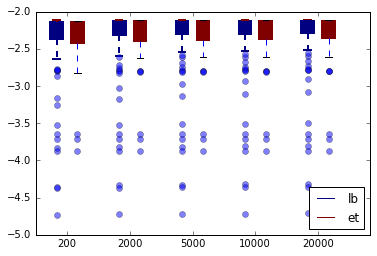

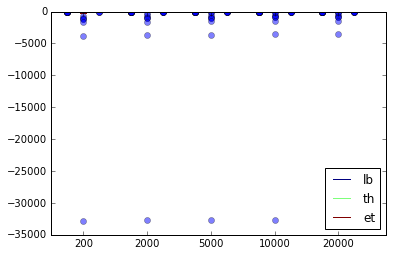

In [81]:
ticks = [200, 2000, 5000, 10000, 20000]
alpha_SGD_lb = 0.9 # 0.0316
alpha_SGD_th = 0.9 # 3.2e-5
alpha_SGD_et = alpha_SGD_lb

update = gradient_updates_2

mem.clear()
#@mem.cache
def lb_fun(lb, fun):
    mu_list, sig_list = train_on_lb(lb, update, alpha=alpha_SGD_lb)
    return [fun(mu_list[tick-1], sig_list[tick-1]) for tick in ticks]

#@mem.cache
def th_fun(th, fun):
    mu_list, sig_list = train_on_th(th, update, alpha=alpha_SGD_th)
    return [fun(mu_list[tick-1], sig_list[tick-1]) for tick in ticks]

#@mem.cache
def et_fun(et, fun):
    mu_list, sig_list = train_on_et(et, update, alpha=alpha_SGD_et)
    return [fun(mu_list[tick-1], sig_list[tick-1]) for tick in ticks]

def kl_fun(m,s):
    return kl(mu_true, sigma2_true, m, s)
def ll_fun(m,s):
    return ave_ll(m, s, Xtest)

SGD_lb_alpha_ll = Parallel(n_jobs=-1, verbose=0)(delayed(lb_fun)(lb, ll_fun) for lb in lb_init)
SGD_th_alpha_ll = Parallel(n_jobs=-1, verbose=0)(delayed(th_fun)(th, ll_fun) for th in th_init)
SGD_et_alpha_ll = Parallel(n_jobs=-1, verbose=0)(delayed(et_fun)(et, ll_fun) for et in et_init)
gboxplot(ticks, [SGD_lb_alpha_ll, SGD_et_alpha_ll] , ['lb', 'et'])
plt.figure()
gboxplot(ticks, [SGD_lb_alpha_ll, SGD_th_alpha_ll, SGD_et_alpha_ll] , ['lb', 'th', 'et'])

In [39]:
ticks = [200, 2000, 5000, 10000, 20000]
alpha_SGD_lb = 0.0316
alpha_SGD_th = 3.2e-5
alpha_SGD_et = alpha_SGD_lb

def lb_ll_kl(lb):
    mu_list, sig_list = train_on_lb(lb, gradient_updates, alpha=alpha_SGD_lb)
    LL = Parallel(n_jobs=-1, verbose=0)(delayed(ave_ll)(mu_list[tick-1], sig_list[tick-1], Xtest) 
                                                 for tick in ticks)
    KL = Parallel(n_jobs=-1, verbose=0)(delayed(kl) (mu_true, sigma2_true, mu_list[tick-1], sig_list[tick-1]) 
                                                 for tick in ticks)
    return LL, KL

def th_ll_kl(th):
    mu_list, sig_list = train_on_th(th, gradient_updates, alpha=alpha_SGD_th)
    LL = Parallel(n_jobs=-1, verbose=0)(delayed(ave_ll)(mu_list[tick-1], sig_list[tick-1], Xtest) 
                                                 for tick in ticks)
    KL = Parallel(n_jobs=-1, verbose=0)(delayed(kl) (mu_true, sigma2_true, mu_list[tick-1], sig_list[tick-1]) 
                                                 for tick in ticks)
    return LL, KL

def et_ll_kl(et):
    mu_list, sig_list = train_on_et(et, gradient_updates, alpha=alpha_SGD_et)
    LL = Parallel(n_jobs=-1, verbose=0)(delayed(ave_ll)(mu_list[tick-1], sig_list[tick-1], Xtest) 
                                                 for tick in ticks)
    KL = Parallel(n_jobs=-1, verbose=0)(delayed(kl) (mu_true, sigma2_true, mu_list[tick-1], sig_list[tick-1]) 
                                                 for tick in ticks)
    return LL, KL

lb_ll_kl_cache = mem.cache(lb_ll_kl)
th_ll_kl_cache = mem.cache(th_ll_kl)
et_ll_kl_cache = mem.cache(et_ll_kl)

In [ ]:
mem.clear()
SGD_lb_alpha = [lb_ll_kl_cache(lb) for lb in lb_init]
SGD_th_alpha = [th_ll_kl_cache(th) for th in th_init]
SGD_et_alpha = [et_ll_kl_cache(et) for et in et_init]

plt.figure()
ll_kl_gboxplot(SGD_lb_alpha, ticks)
plt.savefig('sgd_lb_llkl_bp.png', bbox_inches='tight', dpi=300)

plt.figure()
ll_kl_gboxplot(SGD_th_alpha, ticks)
plt.savefig('sgd_th_llkl_bp.png', bbox_inches='tight', dpi=300)

plt.figure()
ll_kl_gboxplot(SGD_et_alpha, ticks)
plt.savefig('sgd_et_llkl_bp.png', bbox_inches='tight', dpi=300)



#SGD_lb_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_lb_cache)
#                                                  (lb, gradient_updates, alpha=alpha_SGD_lb) for lb in lb_init)
#SGD_th_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_th_cache)
#                                                  (th, gradient_updates, alpha=alpha_SGD_th) for th in th_init)
#SGD_et_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_et_cache)
#                                                  (et, gradient_updates, alpha=alpha_SGD_et) for et in et_init)

In [ ]:
ticks = [200, 2000, 5000, 10000, 20000]
alpha_SGD_lb = 0.0316
alpha_SGD_th = 3.2e-5
alpha_SGD_et = alpha_SGD_lb
SGD_lb_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_lb_cache)
                                                  (lb, gradient_updates, alpha=alpha_SGD_lb) for lb in lb_init)
SGD_th_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_th_cache)
                                                  (th, gradient_updates, alpha=alpha_SGD_th) for th in th_init)
SGD_th_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_et_cache)
                                                  (et, gradient_updates, alpha=alpha_SGD_et) for et in et_init)
for alpha in alphas:
    print ('Alpha = '+str(alpha))
    SGD_lb_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_lb)
                                                  (lb, gradient_updates, alpha=alpha) for lb in lb_init)
    #kl_boxplot(SGD_lb_alpha, ticks)
    mu_sig_plot(SGD_lb_alpha)
    SGD_th_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_th)
                                                  (th, gradient_updates, alpha=alpha) for th in th_init)
    mu_sig_plot(SGD_th_alpha)
    #kl_boxplot(SGD_th_alpha, ticks)
    SGD_et_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_et)
                                                  (et, gradient_updates, alpha=alpha) for et in et_init)
    mu_sig_plot(SGD_et_alpha)
    #kl_boxplot(SGD_et_alpha, ticks)
    
                                                       

In [ ]:
for alpha in alpha2s:
    print ('Alpha = '+str(alpha))
    SGD_lb_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_lb)
                                                  (lb, gradient_updates_2, alpha=alpha) for lb in lb_init)
    #kl_boxplot(SGD_lb_alpha, ticks)
    mu_sig_plot(SGD_lb_alpha)
    SGD_th_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_th)
                                                  (th, gradient_updates_2, alpha=alpha) for th in th_init)
    mu_sig_plot(SGD_th_alpha)
    #kl_boxplot(SGD_th_alpha, ticks)
    SGD_et_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_et)
                                                  (et, gradient_updates_2, alpha=alpha) for et in et_init)
    mu_sig_plot(SGD_et_alpha)
    #kl_boxplot(SGD_et_alpha, ticks)

In [ ]:
for alpha, momentum in it.product(alphas, momentums):
    print ('Alpha = '+str(alpha)+ '    Momentum '+ str(momentum))
    SGD_lb_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_lb)
                                                  (lb, gradient_updates_momentum, alpha=alpha, momentum=momentum)
                                                  for lb in lb_init)
    #kl_boxplot(SGD_lb_alpha, ticks)
    mu_sig_plot(SGD_lb_alpha)
    SGD_th_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_th)
                                                  (th,  gradient_updates_momentum, alpha=alpha, momentum=momentum)
                                                  for th in th_init)
    mu_sig_plot(SGD_th_alpha)
    #kl_boxplot(SGD_th_alpha, ticks)
    SGD_et_alpha = Parallel(n_jobs=-1, verbose=0)(delayed(train_on_et)
                                                  (et,  gradient_updates_momentum, alpha=alpha, momentum=momentum)
                                                  for et in et_init)
    mu_sig_plot(SGD_et_alpha)
    #kl_boxplot(SGD_et_alpha, ticks)

##### results_0005 = [train_on_lb_cache(lb, gradient_updates, alpha=0.005) for lb in lb_init]
ll_boxplot(results_0005, Xt, [200, 2000, 20000])
#ll_boxplot(results_0005, Xt, [200, 2000, 20000])
#results_001 = [train_on_lb_cache(lb, gradient_updates, alpha=0.01) for lb in lb_init]
#ll_boxplot(results_001, Xt, [200, 2000, 20000])
kl_boxplot(results_0005, Xt, [200, 2000, 20000])
#ll_boxplot(results_001, Xt, [200, 2000, 20000])

In [ ]:
np.round(np.linspace(1e-4, 1e-6, 5), 6)